# Ray RLlib Multi-Armed Bandits - Market Bandit Example

© 2019-2021, Anyscale. All Rights Reserved

![Anyscale Academy](../../images/AnyscaleAcademyLogo.png)

Now that we've learned about multi-armed bandits and methods for optimizing rewards, let's look at real-world applications, starting with a stock market example.

How well could you invest in the public markets, if you could only observe one macroeconomic signal *inflation* and could only update your investments once each year?

To explore this, first we'll load a dataset derived from this [NYU Stern table](http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/histretSP.html) that shows returns for nearly a century of market data, including dividends and adjustments for inflation. The `market.tsv` file in this folder contains the data.

In [1]:
import pandas as pd
import numpy as np
import os
import sys

In [2]:
# Some properties we'll need:
DEFAULT_MAX_INFLATION = 100.0
DEFAULT_TICKERS = ["sp500", "t.bill", "t.bond", "corp"]
DEFAULT_DATA_FILE = os.path.abspath(os.path.curdir) + "/market.tsv"  # full path

In [3]:
def load_market_data (file_name):
    with open(file_name, "r") as f:
        return pd.read_table(f)

Let's load and examine the data:

In [4]:
df = load_market_data(DEFAULT_DATA_FILE)
df

,year,inflation,sp500,t.bill,t.bond,corp
0,1928,-1.15,45.49,4.28,2.01,4.42
1,1929,0.00,-8.30,3.16,4.20,3.02
2,1930,-2.67,-23.07,7.42,7.41,3.30
3,1931,-8.93,-38.33,12.34,7.00,-7.41
4,1932,-10.30,1.85,12.68,21.28,37.78
...,...,...,...,...,...,...
87,2015,0.12,1.26,-0.07,1.16,-0.82
88,2016,1.26,10.38,-0.93,-0.56,8.99
89,2017,2.13,19.07,-1.17,0.66,7.44
90,2018,2.44,-6.51,-0.49,-2.40,-5.08


As you can see the data spans 92 years, from 1928 to 2019. 

The columns represent:
  * `year`: the year
  * `inflation`: the inflation rate at the time
  * `sp500`: [S&P500](https://en.wikipedia.org/wiki/S%26P_500_Index) (composite stock index)
  * `t.bill`: [Treasury Bills](https://www.investopedia.com/terms/t/treasurybill.asp) (short-term gov bonds)
  * `t.bond`: [Treasury Bonds](https://www.investopedia.com/terms/t/treasurybond.asp) (long-term gov bonds)
  * `corp`: [Moody's Baa Corporate Bonds](https://en.wikipedia.org/wiki/Moody%27s_Investors_Service#Moody's_credit_ratings) (moderate risk)

## Analysis of the Data

Let's also look at descriptions statistics for each column:

In [5]:
df.describe()

,year,inflation,sp500,t.bill,t.bond,corp
count,92.00000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,1973.50000,3.041957,8.413261,0.434239,2.166413,4.216630
std,26.70206,3.803579,19.619605,3.573035,8.126432,8.625809
min,1928.00000,-10.300000,-38.900000,-12.050000,-14.570000,-14.850000
25%,1950.75000,1.415000,-2.740000,-1.185000,-2.620000,-1.322500
50%,1973.50000,2.750000,10.515000,0.590000,1.070000,3.910000
75%,1996.25000,4.275000,20.622500,2.117500,7.037500,9.287500
max,2019.00000,14.390000,58.200000,12.680000,25.140000,37.780000


What are the worst case and best case scenarios? In other words, if one could predict the future market performance, what are the possible ranges of total failure vs. total success over the past century? By "total", we mean what if you had all your money in a given year invested in the worst performing _sector_ (S&P500, T bills, or other) or you were invested in the best performing sector for that year.

In [6]:
n_years = len(df)
min_list = []
max_list = []

for i in range(n_years):
    row = df.iloc[i, 2:]
    min_list.append(min(row))
    max_list.append(max(row))
    
print("{:5.2f}% worst case annualized".format(sum(min_list) / n_years))
print("{:5.2f}% best case annualized".format(sum(max_list) / n_years))

-5.64% worst case annualized
15.18% best case annualized


In [7]:
min_max = pd.DataFrame.from_dict({'year': df['year'], 'min':min_list, 'max':max_list})
min_max

,year,min,max
0,1928,2.01,45.49
1,1929,-8.30,4.20
2,1930,-23.07,7.42
3,1931,-38.33,12.34
4,1932,1.85,37.78
...,...,...,...
87,2015,-0.82,1.26
88,2016,-0.93,10.38
89,2017,-1.17,19.07
90,2018,-6.51,-0.49


We can visualize the best and worst returns, year over year.
Overall this should look like a [*random walk*](https://en.wikipedia.org/wiki/Random_walk):

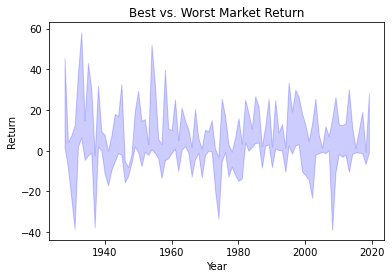

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.fill_between(
    df["year"],
    min_list,
    max_list,
    color="b",
    alpha=0.2
)

plt.title("Best vs. Worst Market Return")
plt.xlabel("Year")
plt.ylabel("Return")
plt.show()

There are some years where the performance varies widely, while other years everything returns about the same performance.

## Defining an Environment

Now let's define a Gym environment so that we can train a contextual bandit to optimize annual investments over that period.

In [9]:
import gym
from gym.spaces import Discrete, Box
from gym.utils import seeding
import random

This is the bandit we'll use to represent the market "environment".

In [10]:
class MarketBandit (gym.Env):
    
    def __init__ (self, config={}):
        self.max_inflation = config.get("max-inflation", DEFAULT_MAX_INFLATION)
        self.tickers = config.get("tickers", DEFAULT_TICKERS)
        self.data_file = config.get("data-file", DEFAULT_DATA_FILE)
        print(f"MarketBandit: max_inflation: {self.max_inflation}, tickers: {self.tickers}, data file: {self.data_file} (config: {config})")

        self.action_space = Discrete(4)
        self.observation_space = Box(
            low  = -self.max_inflation,
            high =  self.max_inflation,
            shape=(1, )
        )
        self.df = load_market_data(self.data_file)
        self.cur_context = None


    def reset (self):
        self.year = self.df["year"].min()
        self.cur_context = self.df.loc[self.df["year"] == self.year]["inflation"][0]
        self.done = False
        self.info = {}

        return [self.cur_context]


    def step (self, action):
        if self.done:
            reward = 0.
            regret = 0.
        else:
            row = self.df.loc[self.df["year"] == self.year]

            # calculate reward
            ticker = self.tickers[action]
            reward = float(row[ticker])

            # calculate regret
            max_reward = max(map(lambda t: float(row[t]), self.tickers))
            regret = round(max_reward - reward)

            # update the context
            self.cur_context = float(row["inflation"])

            # increment the year
            self.year += 1

            if self.year >= self.df["year"].max():
                self.done = True

        context = [self.cur_context]
        #context = self.observation_space.sample()

        self.info = {
            "regret": regret,
            "year": self.year
        }
         
        return [context, reward, self.done, self.info]


    def seed (self, seed=None):
        """Sets the seed for this env's random number generator(s).
        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.
        Returns:
            list<bigint>: Returns the list of seeds used in this env's random
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

Let's see it in action:

In [11]:
bandit = MarketBandit()
bandit.reset()

for i in range(10):
    action = bandit.action_space.sample()
    obs = bandit.step(action)
    print(action, obs)

MarketBandit: max_inflation: 100.0, tickers: ['sp500', 't.bill', 't.bond', 'corp'], data file: /home/paco/Github/rllib_tutorials/rl_apps/multi-armed-bandits/market.tsv (config: {})
3 [[-1.15], 4.42, False, {'regret': 41, 'year': 1929}]
3 [[0.0], 3.02, False, {'regret': 1, 'year': 1930}]
0 [[-2.67], -23.07, False, {'regret': 30, 'year': 1931}]
2 [[-8.93], 7.0, False, {'regret': 5, 'year': 1932}]
3 [[-10.3], 37.78, False, {'regret': 0, 'year': 1933}]
1 [[-5.19], 6.49, False, {'regret': 52, 'year': 1934}]
2 [[3.48], 4.33, False, {'regret': 10, 'year': 1935}]
1 [[2.55], -2.33, False, {'regret': 45, 'year': 1936}]
0 [[1.03], 30.6, False, {'regret': 0, 'year': 1937}]
0 [[3.73], -37.66, False, {'regret': 35, 'year': 1938}]


We can use this environment in a kind of [*monte carlo simulation*](https://en.wikipedia.org/wiki/Monte_Carlo_method) to measure a baseline for what the rewards would be over a long period if you merely used actions selected at random.

In [12]:
done = 1
reward_list = []
iterations = 10000 #50000

for i in range(iterations):
    if done == 1:
        bandit.reset()

    action = bandit.action_space.sample()
    obs = bandit.step(action)
    context, reward, done, info = obs
    reward_list.append(reward)
    #print(action, context, reward, done, info)

In [13]:
df_mc = pd.DataFrame(reward_list, columns=["reward"])
df_mc.mean()

reward    3.704882
dtype: float64

Depending on the number of iterations, you'll probably get a value approaching 3.75% as a baseline for random actions. That's more than the -5.64% worst case and must less than 15.18% best case for the reward!

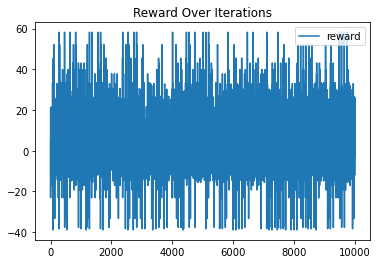

In [14]:
df_mc.plot(y="reward", title="Reward Over Iterations")

([image](../../images/rllib/MarketReward-Random.png))

Yes, it looks quite random... There is no improvement (i.e., *learning*) happening at all.

## Training a policy in RLlib

Now let's train a policy using our contextual bandit, specifically using _Linear Thompson Sampling_ in RLlib. Hopefully it will do better than the random results we just computed!

Recall in the `__init__()` method for `MarketBandit` that we set some parameters from the passed in `config` object. 
So we need to create a custom config object with our parameters, by building on the default `TS_CONFIG` object for _LinTS_:

In [15]:
import copy
from ray.rllib.contrib.bandits.agents.lin_ts import TS_CONFIG

market_config = copy.deepcopy(TS_CONFIG)

market_config["env"] = MarketBandit
market_config["max-inflation"] = DEFAULT_MAX_INFLATION;
market_config["tickers"] = DEFAULT_TICKERS;
market_config["data-file"] = DEFAULT_DATA_FILE;

Instructions for updating:
non-resource variables are not supported in the long term


We'll also define a custom trainer, which builds on the `LinTSTrainer` with "updates". 
This will be the first argument that we'll pass to `ray.tune.run()` later. 

Note: if all we needed was the default `LinTSTrainer` trainer, as is and with no customized config settings, we could instead just pass the string `"contrib/LinTS"` to `ray.tune.run()`.  

In [16]:
from ray.rllib.contrib.bandits.agents.lin_ts import LinTSTrainer

MarketLinTSTrainer = LinTSTrainer.with_updates(
    name="MarketLinTSTrainer",
    default_config=market_config,      # Will be merged with Trainer.COMMON_CONFIG (rllib/agent/trainer.py)
    #default_policy=[somePolicyClass]  # If we had a policy...
)

Then initialize Ray:

In [17]:
import ray

ray.init(ignore_reinit_error=True)

2021-05-22 13:32:48,818	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '192.168.1.156',
 'raylet_ip_address': '192.168.1.156',
 'redis_address': '192.168.1.156:48645',
 'object_store_address': '/tmp/ray/session_2021-05-22_13-32-48_217092_31145/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-22_13-32-48_217092_31145/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-05-22_13-32-48_217092_31145',
 'metrics_export_port': 57965,
 'node_id': '36516eae943a9cc17541478555dc950d83c4f12860a789ef7803f076'}

Then run Tune:

In [18]:
stop = {
    "training_iteration": 100
}

analysis = ray.tune.run(
    MarketLinTSTrainer,
    config=market_config,
    stop=stop,
    num_samples=3,
)

Trial name,status,loc
MarketLinTSTrainer_MarketBandit_e187a_00000,RUNNING,


(pid=31282) WARNING:tensorflow:From /home/paco/anaconda3/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=31282) Instructions for updating:
(pid=31282) non-resource variables are not supported in the long term
(pid=31280) WARNING:tensorflow:From /home/paco/anaconda3/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=31280) Instructions for updating:
(pid=31280) non-resource variables are not supported in the long term
(pid=31281) WARNING:tensorflow:From /home/paco/anaconda3/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=31281) Instruction

(pid=31282) MarketBandit: max_inflation: 100.0, tickers: ['sp500', 't.bill', 't.bond', 'corp'], data file: /home/paco/Github/rllib_tutorials/rl_apps/multi-armed-bandits/market.tsv (config: {})
(pid=31280) MarketBandit: max_inflation: 100.0, tickers: ['sp500', 't.bill', 't.bond', 'corp'], data file: /home/paco/Github/rllib_tutorials/rl_apps/multi-armed-bandits/market.tsv (config: {})
(pid=31281) MarketBandit: max_inflation: 100.0, tickers: ['sp500', 't.bill', 't.bond', 'corp'], data file: /home/paco/Github/rllib_tutorials/rl_apps/multi-armed-bandits/market.tsv (config: {})
Result for MarketLinTSTrainer_MarketBandit_e187a_00000:
  custom_metrics: {}
  date: 2021-05-22_13-32-54
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 607.3800000000001
  episode_reward_mean: 607.3800000000001
  episode_reward_min: 607.3800000000001
  episodes_this_iter: 1
  episodes_total: 1
  experiment_id: 097aab642f0140209cc35b58ec990512
  hostname: paco-kf
  info:
    learner:
      default_policy:

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_e187a_00000,RUNNING,192.168.1.156:31280,17,3.09187,1700,612.177,749.27,396.71,91
MarketLinTSTrainer_MarketBandit_e187a_00001,RUNNING,192.168.1.156:31281,17,3.07641,1700,619.75,791.11,427.76,91
MarketLinTSTrainer_MarketBandit_e187a_00002,RUNNING,192.168.1.156:31282,17,3.07991,1700,532.936,642.8,448.52,91


Result for MarketLinTSTrainer_MarketBandit_e187a_00000:
  custom_metrics: {}
  date: 2021-05-22_13-32-59
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 749.2700000000001
  episode_reward_mean: 601.4078125
  episode_reward_min: 396.71000000000004
  episodes_this_iter: 1
  episodes_total: 32
  experiment_id: 097aab642f0140209cc35b58ec990512
  hostname: paco-kf
  info:
    learner:
      default_policy:
        cumulative_regret: 25284
        update_latency: 0.00018286705017089844
    num_steps_sampled: 3000
    num_steps_trained: 3000
  iterations_since_restore: 30
  node_ip: 192.168.1.156
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf: {}
  pid: 31280
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.029762965588392004
    mean_env_wait_ms: 0.7220139288689826
    mean_inference_ms: 0.493384747103245
    mean_raw_obs_processing_ms: 0.20112728826403864
  time_since_restore: 5.033671140670776

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_e187a_00000,RUNNING,192.168.1.156:31280,45,7.77314,4500,605.832,749.27,396.71,91
MarketLinTSTrainer_MarketBandit_e187a_00001,RUNNING,192.168.1.156:31281,44,7.74977,4400,613.841,791.11,413.23,91
MarketLinTSTrainer_MarketBandit_e187a_00002,RUNNING,192.168.1.156:31282,45,7.90471,4500,557.566,759.46,437.43,91


Result for MarketLinTSTrainer_MarketBandit_e187a_00000:
  custom_metrics: {}
  date: 2021-05-22_13-33-04
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 749.2700000000001
  episode_reward_mean: 603.0165573770494
  episode_reward_min: 396.71000000000004
  episodes_this_iter: 1
  episodes_total: 61
  experiment_id: 097aab642f0140209cc35b58ec990512
  hostname: paco-kf
  info:
    learner:
      default_policy:
        cumulative_regret: 47122
        update_latency: 0.00020194053649902344
    num_steps_sampled: 5600
    num_steps_trained: 5600
  iterations_since_restore: 56
  node_ip: 192.168.1.156
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf: {}
  pid: 31280
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.028981576505808473
    mean_env_wait_ms: 0.7055551507751929
    mean_inference_ms: 0.48469541641656894
    mean_raw_obs_processing_ms: 0.19683735177416467
  time_since_restore: 9.8326175

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_e187a_00000,RUNNING,192.168.1.156:31280,74,12.6424,7400,594.166,749.27,396.71,91
MarketLinTSTrainer_MarketBandit_e187a_00001,RUNNING,192.168.1.156:31281,73,12.7047,7300,607.537,851.67,413.23,91
MarketLinTSTrainer_MarketBandit_e187a_00002,RUNNING,192.168.1.156:31282,73,12.6361,7300,570.679,759.46,356.57,91


Result for MarketLinTSTrainer_MarketBandit_e187a_00000:
  custom_metrics: {}
  date: 2021-05-22_13-33-09
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 749.2700000000001
  episode_reward_mean: 593.8506315789474
  episode_reward_min: 396.71000000000004
  episodes_this_iter: 1
  episodes_total: 95
  experiment_id: 097aab642f0140209cc35b58ec990512
  hostname: paco-kf
  info:
    learner:
      default_policy:
        cumulative_regret: 73946
        update_latency: 0.00024390220642089844
    num_steps_sampled: 8700
    num_steps_trained: 8700
  iterations_since_restore: 87
  node_ip: 192.168.1.156
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 20.9
    ram_util_percent: 10.5
  pid: 31280
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.028539341000555298
    mean_env_wait_ms: 0.6965357773831106
    mean_inference_ms: 0.47998446348800144
    mean_raw_obs_processing_ms: 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_e187a_00000,TERMINATED,,100,17.0901,10000,595.296,749.27,419.27,91
MarketLinTSTrainer_MarketBandit_e187a_00001,TERMINATED,,100,17.2645,10000,603.18,851.67,413.23,91
MarketLinTSTrainer_MarketBandit_e187a_00002,TERMINATED,,100,17.1718,10000,577.993,759.46,356.57,91


2021-05-22 13:33:12,247	INFO tune.py:450 -- Total run time: 20.15 seconds (19.96 seconds for the tuning loop).


In [19]:
stats = analysis.stats()
secs = stats["timestamp"] - stats["start_time"]
print(f'{secs:7.2f} seconds, {secs/60.0:7.2f} minutes')

  19.96 seconds,    0.33 minutes


## Analyzing the results

Let's analyze the rewards and cumulative regrets from these trials.

In [20]:
df_ts = pd.DataFrame()

for key, df_trial in analysis.trial_dataframes.items():
    df_ts = df_ts.append(df_trial, ignore_index=True)
    
df_ts.head()

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_healthy_workers,timesteps_total,done,episodes_total,training_iteration,...,timers/sample_time_ms,timers/sample_throughput,timers/learn_time_ms,timers/learn_throughput,info/num_steps_sampled,info/num_steps_trained,perf/cpu_util_percent,perf/ram_util_percent,info/learner/default_policy/cumulative_regret,info/learner/default_policy/update_latency
0,607.38,607.38,607.380000,91.0,1,0,100,False,1,1,...,1.511,661.716,0.225,4452.552,100,100,17.8,10.5,881,0.000176
1,655.21,607.38,631.295000,91.0,1,0,200,False,2,2,...,1.344,744.216,0.212,4707.940,200,200,NaN,NaN,1671,0.000166
2,658.26,607.38,640.283333,91.0,1,0,300,False,3,3,...,1.339,746.883,0.214,4676.967,300,300,NaN,NaN,2489,0.000160
3,658.26,583.14,625.997500,91.0,1,0,400,False,4,4,...,1.567,638.042,0.254,3939.423,400,400,22.1,10.5,3319,0.000188
4,658.26,492.63,599.324000,91.0,1,0,500,False,5,5,...,1.704,587.024,0.280,3577.537,500,500,NaN,NaN,4203,0.000216


In [21]:
rewards = df_ts \
    .groupby("info/num_steps_trained")["episode_reward_mean"] \
    .aggregate(["mean", "max", "min", "std"])

rewards

,mean,max,min,std
info/num_steps_trained,,,,
100,622.106667,680.080000,578.8600,52.192223
200,589.020000,631.295000,553.9200,39.183327
300,599.367778,640.283333,541.1000,51.818511
400,602.623333,651.457500,530.4150,63.816812
500,591.602667,630.650000,544.8340,43.425922
...,...,...,...,...
9600,590.889667,601.961000,576.5232,13.035100
9700,591.114500,602.232300,575.9479,13.601912
9800,591.967067,602.743900,576.4777,13.752610


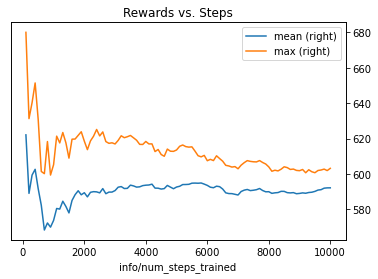

In [22]:
rewards.plot(y=["mean", "max"], secondary_y=True, title="Rewards vs. Steps")

The rewards bounce around at first, then appear to stabilize after 5000 steps, with slow improvement afterwards.

In [23]:
regrets = df_ts \
    .groupby("info/num_steps_trained")["info/learner/default_policy/cumulative_regret"] \
    .aggregate(["mean", "max", "min", "std"])

regrets

,mean,max,min,std
info/num_steps_trained,,,,
100,902.333333,965,861,55.184539
200,1777.000000,1836,1671,91.994565
300,2591.333333,2830,2455,207.389328
400,3453.333333,3772,3269,277.103470
500,4290.666667,4493,4176,175.745081
...,...,...,...,...
9600,81976.000000,83679,80763,1518.498930
9700,82895.666667,84604,81712,1515.708525
9800,83683.333333,85474,82428,1592.000419


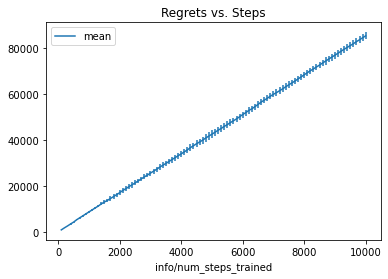

In [24]:
regrets.plot(y="mean", yerr="std", title="Regrets vs. Steps")

## Evaluating the Trained Policy

Overall, how well did the trained policy perform? The results should be better than random, but less than the best case.

In [25]:
print("{:5.2f}% optimized return annualized".format(max(rewards["mean"]) / n_years))

 6.76% optimized return annualized


You should see a number between near 6%. That's better than the random action baseline of 3.75%, but no where near the best case scenario of 15.18% return. Hence, our regrets continue to grow over time...

Note that investing solely in the S&P stock index which would have produced better than 8% return over that period -- that is, if one could wait 92 years. However, investing one's entire portfolio into stocks can become quite a risky policy in the short-term, so we were exploring how to balance a portfolio given only limited information.

In any case, the contextual bandit performed well considering that it could only use *inflation* for the context of its decisions, and could only take actions once each year.

## Exercise 1

Try using a `LinUCBTrainer`-based trainer.

How does the annualized return compare?

## Exercise 2

Inflation rates tend to get reported months after they've occurred. To be more accurate with using this dataset, offset the *inflation* observation one step (1 year) ahead.

How does the annualized return compare?

---

## Extra - Restoring from a Checkpoint

In the previous lesson, [05 Thompson Sampling](05-Thompson-Sampling.ipynb), we showed how to restore a trainer from a checkpoint, but almost "in passing". Let's use this feature again, this time with our custom trainer class `MarketLinTSTrainer`.

In [ ]:
trial = analysis.trials[0]
path = trial.checkpoint.value
print(f'checkpoint_path: {path}')

In [ ]:
trainer = MarketLinTSTrainer(market_config)  # create instance and then restore from checkpoint
trainer.restore(path)

Access the model, to review the distribution of arm weights

In [ ]:
model = trainer.get_policy().model
means = [model.arms[i].theta.numpy() for i in range(3)]
covs = [model.arms[i].covariance.numpy() for i in range(3)]
means, covs, model.arms[0].theta.numpy()

A final note: using checkpoints will change how the training performs in this notebook, if you rerun it. So be sure to start from scratch when doing experiments here, if that's what you intend!

In [26]:
ray.shutdown()